In [1]:
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt

In [ ]:
def combine_md_datetime(df, date_col='MDDate', time_col='MDTime', new_col='DateTime',drop_original=True):
    """
    日期和时间合并为标准datetime
    """
    df[date_col] = df[date_col].astype(str)
    df[time_col] = df[time_col].astype(str).str.zfill(9)
    datetime_str = df[date_col] + ' ' + df[time_col].str[:6]
    df[new_col] = pd.to_datetime(datetime_str, format='%Y%m%d %H%M%S')
    
    if drop_original:
        df.drop(columns=[date_col, time_col], inplace=True)
    return df

In [ ]:
# Load the data
fut = pd.read_csv('AU00.SHF_20250101_20250630.csv',usecols=['ReceiveDateTime', 'LastPx','Buy1Price','Sell1Price'])
au = pd.read_csv("AU99.99.SGE_20250101_20250630.csv",usecols=['ReceiveDateTime', 'LastPx','Buy1Price','Sell1Price'])

#清洗
#区分价格
fut.rename(columns={'LastPx': 'ETF_Price','Buy1Price':'ETF_Buy1Price','Sell1Price':'ETF_Sell1Price'}, inplace=True)
au.rename(columns={'LastPx': 'AU_Price','Buy1Price':'AU_Buy1Price','Sell1Price':'AU_Sell1Price'}, inplace=True)

#删去0值
fut = fut[fut['ETF_Price'] != 0]
au = au[au['AU_Price'] != 0]

#时间规范
fut = combine_md_datetime(fut)
au = combine_md_datetime(au)

#对齐
merged = pd.merge_asof(fut,au,on='DateTime',direction='backward')

In [ ]:
merged.head(10)

In [7]:
# 对数价格
merged['log_fut'] = np.log(merged['FUT_Price'])
merged['log_au'] = np.log(merged['AU_Price'])

# 回归拟合 beta
X = add_constant(merged['log_au'])
y = merged['log_fut']
model = OLS(y, X).fit()
beta = model.params[1]
print(f"Estimated beta: {beta:.4f}")

# 构造 spread 与 zscore
window = 300
merged['spread'] = merged['log_fut'] - beta * merged['log_au']
merged['spread_mean'] = merged['spread'].rolling(window=window).mean()
merged['spread_std'] = merged['spread'].rolling(window=window).std()
merged['zscore'] = (merged['spread'] - merged['spread_mean']) / merged['spread_std']

/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_3828/2297237806.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Estimated beta: 1.0057


/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_3828/556830765.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/guziyi/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


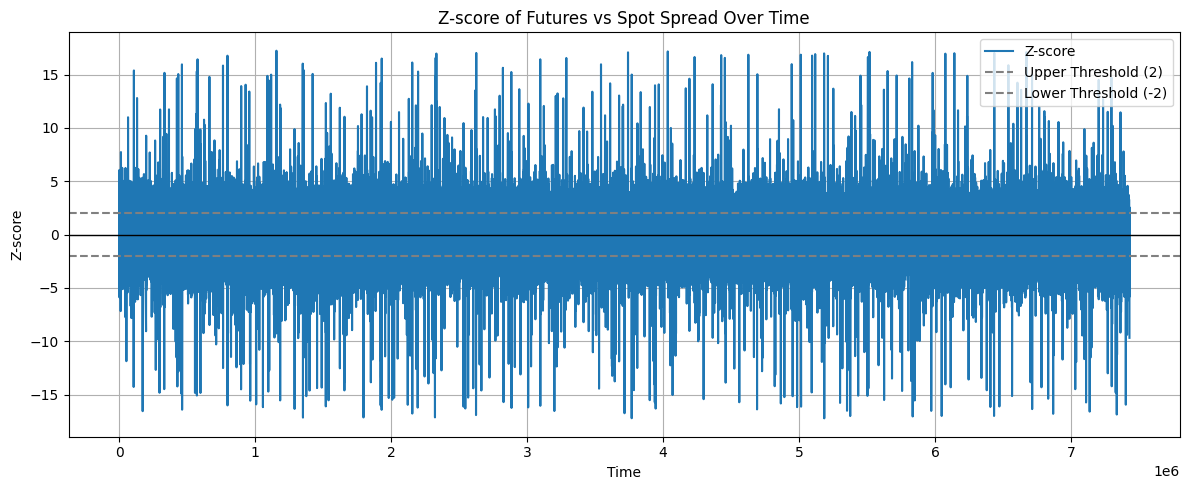

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(merged.index, merged['zscore'], label='Z-score')
plt.axhline(2, color='gray', linestyle='--', label='Upper Threshold (2)')
plt.axhline(-2, color='gray', linestyle='--', label='Lower Threshold (-2)')
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.title("Z-score of Futures vs Spot Spread Over Time")
plt.xlabel("Time")
plt.ylabel("Z-score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()